In [1]:
import matplotlib.pyplot as plt

In [2]:
def show_book(figname):
    print(r"Siehe Abbildung §\ref{fig_XXX}§".replace("XXX", figname))
    plt.savefig(f"{figname}_snip.pdf")
    plt.show()

# Wärmeleitung

`begin heat_setup`

In [3]:
a = 0.1  # K/(m²s)

# Abtastzeit der Iteration ist 2 ms
dt = 0.002
# Gesamtzeit ist 1 s
T = 1.0
steps = int(T/dt) # Anzahl der Zeitschritte

# Gitterdimension 1 x 1 m
grid_dim = (1, 1)
# 25 Gitterpunkte auf jeder Achse
grid_samples = (25, 25)

`end`

In [4]:
dx, dy = grid_dim[0] / grid_samples[0], grid_dim[1] / grid_samples[1]
max_dt = 1/(2*a)*(dx*dy)**2/(dx**2+dy**2)
print('Max dt:', max_dt)
if dt >= max_dt:
    print("Sim will freak out")
else:
    print("Sim should converge")

Max dt: 0.003999999999999999
Sim should converge


In [5]:
import matplotlib.pyplot as plt
def plot_heat_grid(u, grid_dim):
    plt.imshow(u.T, cmap='coolwarm', origin='lower', extent=(0, grid_dim[0], 0, grid_dim[1]))
    plt.colorbar(label="Temperatur [°C]")

`begin heat_sim_numpy`

In [6]:
import numpy as np
def sim_heat_equation_numpy(a, grid_dim, grid_samples, dt, steps):
    dx, dy = grid_dim[0] / grid_samples[0], grid_dim[1] / grid_samples[1]
    # Anfangsbedingungen: alles 0°C
    u = np.zeros(grid_samples)
    
    # Definiere Maske um Temperatur auf Scheibe in Schleife zu setzen
    disk_mask = np.zeros_like(u, dtype=bool)
    for xi in range(grid_samples[0]):
        for yi in range(grid_samples[1]):
            # Scheibe mit Radius 0.1 und Mittelpunkt (0.5, 0.5)
            if (xi*dx - 0.5)**2 + (yi*dy - 0.5)**2 < 0.1**2:
                disk_mask[xi,yi] = True

    for i in range(steps):  # Simulationsschleife
        # Setze Randwerte
        u[0,:] = u[1,:]  # Neumann am linken Rand
        u[-1,:] = u[-2,:] # Neumann am rechten Rand
        u[:,0] = 0 # Dirichlet (0°C) am unteren Rand
        u[:,-1] = 50 # Dirichlet (50°C) am oberen Rand
        u[disk_mask] = 50  # Erhitzte Scheibe (50°C)
        # Diskretisierte Wärmeleitungsgleichung
        u[1:-1,1:-1] += a*dt*((u[2:,1:-1] + u[:-2,1:-1] - 2*u[1:-1,1:-1])/(dx**2) +
                              (u[1:-1,2:] + u[1:-1,:-2] - 2*u[1:-1,1:-1])/(dy**2))
    
    return u

`end`

`begin heat_sim_python_loops`

In [7]:
import numpy as np
def sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps):
    dx, dy = grid_dim[0] / grid_samples[0], grid_dim[1] / grid_samples[1]
    # Anfangsbedingungen: alles 0°C
    u = np.zeros(grid_samples)

    for i in range(steps):  # Simulationsschleife
        for xi in range(grid_samples[0]):
            for yi in range(grid_samples[1]):
                if xi == 0: # Neumann am linken Rand
                    u[0,yi] = u[1,yi]
                elif xi == grid_samples[0] - 1: # Neumann am rechten Rand
                    u[-1,yi] = u[-2,yi]
                elif yi == 0: # Dirichlet am unteren Rand
                    u[xi,0] = 0
                elif yi == grid_samples[1] - 1: # Dirichlet am oberen Rand
                    u[xi,-1] = 50
                elif (xi*dx - 0.5)**2 + (yi*dy - 0.5)**2 < 0.1**2:
                    u[xi,yi] = 50  # Erhitzte Scheibe (50°C)
                else:
                    # Diskretisierte Wärmeleitungsgleichung
                    u[xi,yi] += a*dt*((u[xi+1,yi] + u[xi-1,yi] - 2*u[xi,yi])/(dx**2) +
                                      (u[xi,yi+1] + u[xi,yi-1] - 2*u[xi,yi])/(dy**2))
    
    return u

`end`

`begin heat_sim_python_loops_numba`

In [8]:
from numba import jit
#!@jit
#!def sim_heat_equation_numba(a, grid_dim, grid_samples, dt, steps):
#!    # Code aus sim_heat_equation_python_loops 1:1 kopieren
#!    ...

`end`

In [9]:
@jit
def sim_heat_equation_numba(a, grid_dim, grid_samples, dt, steps):
    dx, dy = grid_dim[0] / grid_samples[0], grid_dim[1] / grid_samples[1]
    u = np.zeros(grid_samples)

    for i in range(steps):  # Simulationsschleife
        for xi in range(grid_samples[0]):
            for yi in range(grid_samples[1]):
                if xi == 0: # Neumann am linken Rand
                    u[0,yi] = u[1,yi]
                elif xi == grid_samples[0] - 1: # Neumann am rechten Rand
                    u[-1,yi] = u[-2,yi]
                elif yi == 0: # Dirichlet am unteren Rand
                    u[xi,0] = 0
                elif yi == grid_samples[1] - 1: # Dirichlet am oberen Rand
                    u[xi,-1] = 50
                elif (xi*dx - 0.5)**2 + (yi*dy - 0.5)**2 < 0.1**2:
                    u[xi,yi] = 50
                else:
                    u[xi,yi] += a*dt*((u[xi+1,yi] + u[xi-1,yi] - 2*u[xi,yi])/(dx**2) +
                                      (u[xi,yi+1] + u[xi,yi-1] - 2*u[xi,yi])/(dy**2))
    
    return u

`begin timeit_python_loops`

In [10]:
#!%timeit sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps)
print("1.87 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)")#!

1.87 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`end`

`begin timeit_numpy`

In [11]:
#!%timeit sim_heat_equation_numpy(a, grid_dim, grid_samples, dt, steps)
print("31.8 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)")#!

31.8 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


`end`

`begin timeit_numba`

In [12]:
# Erster Aufruf ist Aufwärmung und kompiliert die Funktionenn
#!sim_heat_equation_numba(a, grid_dim, grid_samples, dt, steps)
# Jetzt (nach Kompilierung) ist Zeitmessung sinnvoll
#!%timeit sim_heat_equation_numba(a, grid_dim, grid_samples, dt, steps)
print("4.05 ms ± 86.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)")#!

4.05 ms ± 86.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`end`

Siehe Abbildung §\ref{fig_heat_sim}§


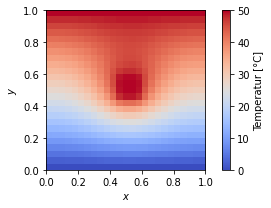

In [34]:
u = sim_heat_equation_numpy(a, grid_dim, grid_samples, dt, steps)
plt.figure(figsize=(5, 3))
plot_heat_grid(u, grid_dim)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
show_book('heat_sim')

# Visualisierung Laplace-Operator

Siehe Abbildung §\ref{fig_laplace_sketch}§


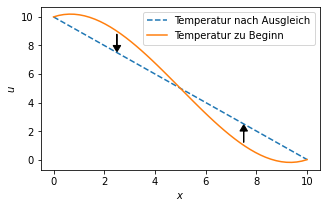

In [14]:
import numpy as np
from scipy.interpolate import interp1d
xx = np.linspace(0, 10)
straight_fun = interp1d([0, 10], [10, 0])
yy_straight = straight_fun(xx)
bendy_points = np.array([[0, 10], [2.5, 9], [5, 5], [7.5, 1], [10, 0]])
bendy_fun = interp1d(bendy_points[:,0], bendy_points[:,1], 'cubic')
yy_bendy = bendy_fun(xx)

plt.figure(figsize=(5,3))
plt.plot(xx, yy_straight, '--', label='Temperatur nach Ausgleich')
plt.plot(xx, yy_bendy, label='Temperatur zu Beginn')
plt.arrow(2.5, 8.8, 0, -0.8, head_width=0.3, fc="k")
plt.arrow(7.5, 1.2, 0, 0.8, head_width=0.3, fc="k")
plt.legend()
plt.ylabel('$u$')
plt.xlabel('$x$')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelleft=False, labelbottom=False)
#plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
show_book('laplace_sketch')
#plt.plot(bendy_points[:,0], bendy_points[:,1], 'o')

# Performance messen

`begin perf_counter`

In [15]:
import time
#!time.perf_counter()  # Zeit in s seit undefiniertem Punkt
print("31.8312628")#!

31.8312628

`end`

`begin perf_counter_sim`

In [16]:
start_time = time.perf_counter()  # Startzeit merken
sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps)
time.sleep(2)  # "Inaktive" Zeit wird mit gemessen
sim_time = time.perf_counter() - start_time  # Aktuelle Zeit - Startzeit
#!print(f"Simulation braucht {sim_time} s (Wanduhr-Zeit)")
print("Simulation braucht 4.069655700000002 s (Wanduhr-Zeit)")#!

Simulation braucht 4.069655700000002 s (Wanduhr-Zeit)


`end`

`begin timedelta`

In [17]:
import datetime
long_time_seconds = 2*60*60 + 19*60 + 42 + 0.25 # 2h 19m 42s 250ms
# Menschenlesbare Ausgabe in einzelnen Einheiten
str(datetime.timedelta(seconds=long_time_seconds)) 

'2:19:42.250000'

`end`

`begin process_time_sim`

In [18]:
start_time = time.process_time()
sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps)
time.sleep(2)  # Inaktive Zeit wird nicht gemessen
sim_time = time.process_time() - start_time
#!print(f"Simulation braucht {sim_time} s (Prozessorzeit)")
print("Simulation braucht 1.84375 s (Prozessorzeit)")#!

Simulation braucht 1.84375 s (Prozessorzeit)


`end`

## timeit

`begin timeit_sim`

In [19]:
import timeit
nr_runs = 4  # Wie oft soll die Funktion ausgeführt werden?
# timeit.timeit nimmt eine ausführbare Funktion ohne Argumente
#!time_per_run = timeit.timeit(lambda: sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps), number=nr_runs) / nr_runs
#!print(f"Simulation braucht {time_per_run} s (Wanduhr-Zeit)")
print("Simulation braucht 2.0994281249999993 s (Wanduhr-Zeit)")#!

Simulation braucht 2.0994281249999993 s (Wanduhr-Zeit)


`end`

`begin timeit_magic`

In [20]:
#!%timeit sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps)
print("1.97 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)")#!

1.97 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`end`

In [21]:
import numpy as np

`begin timeit_repeat`

In [22]:
run_times = np.array(timeit.repeat(lambda: sim_heat_equation_python_loops(a, grid_dim, grid_samples, dt, steps), number=nr_runs, repeat=3))
run_times

array([7.5460774, 7.0870385, 7.7462764])

In [23]:
print(f"Zeit pro Aufruf: {np.mean(run_times/nr_runs)} s ± {np.std(run_times/nr_runs)*1000} ms")

Zeit pro Aufruf: 1.8649493583333328 s ± 68.99028515097449 ms


`end`

# C-Code

In [24]:
#!C:\dev\mingw-w64\i686-8.1.0-posix-dwarf-rt_v6-rev0\mingw32\bin\gcc.exe -c -fpic -lm heat_sim.c
#!C:\dev\mingw-w64\i686-8.1.0-posix-dwarf-rt_v6-rev0\mingw32\bin\gcc.exe -shared -o libheatsim.so heat_sim.o

`begin ct_loadlib`

In [25]:
import ctypes
lib = ctypes.cdll.LoadLibrary(r"C:\dev\pfifd\code\kap_perf\libheatsim.so")#!
#!lib = ctypes.cdll.LoadLibrary("libheatsim.so")

`end`

`begin ct_def_fun`

In [26]:
import numpy as np
# Hilfstyp für NumPy-Arrays und ctypes
from numpy.ctypeslib import ndpointer
c_heat_sim = lib.heatSim
c_heat_sim.argtypes = [ndpointer(ctypes.c_float, ndim=2), ctypes.c_float,
                       ctypes.c_uint, ctypes.c_uint,
                       ctypes.c_float, ctypes.c_float,
                       ctypes.c_float, ctypes.c_uint]
c_heat_sim.restype = ctypes.c_uint

`end`

`begin ct_wrapper`

In [27]:
def sim_heat_equation_c(a, grid_dim, grid_samples, dt, steps):
    dx, dy = grid_dim[0] / grid_samples[0], grid_dim[1] / grid_samples[1]
    u = np.zeros(grid_samples, dtype=np.float32)  # Datentyp explizit auf C float setzen
    # c_heat_sim als Python-Funktion aufrufen. Rückgabewert ist die Anzahl
    # an Schleifendurchläufen
    loop_counter = c_heat_sim(u, a, grid_samples[0], grid_samples[1], dx, dy, dt, steps)
    return u

`end`

`begin timeit_c`

In [28]:
#!%timeit sim_heat_equation_c(a, grid_dim, grid_samples, dt, steps)
print("17.2 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)") #!

17.2 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


`end`

In [29]:
libHandle = lib._handle
del lib
ctypes.windll.kernel32.FreeLibrary(libHandle)

1

# Profiling

`begin profiling_beispiel --input_prefix=""`

In [30]:
import time
def schnarchnase():
    time.sleep(0.5)

def ruckizucki():
    time.sleep(0.001)

def profiling_beispiel(n):
    schnarchnase()
    for i in range(n):
        ruckizucki()

`end`

`begin profile_fast`

In [31]:
import cProfile

In [32]:
cProfile.run("profiling_beispiel(10)")

         26 function calls in 0.665 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.508    0.508 <ipython-input-30-97c425bea2eb>:2(schnarchnase)
       10    0.000    0.000    0.156    0.016 <ipython-input-30-97c425bea2eb>:5(ruckizucki)
        1    0.001    0.001    0.665    0.665 <ipython-input-30-97c425bea2eb>:8(profiling_beispiel)
        1    0.000    0.000    0.665    0.665 <string>:1(<module>)
        1    0.000    0.000    0.665    0.665 {built-in method builtins.exec}
       11    0.664    0.060    0.664    0.060 {built-in method time.sleep}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




`end`

`begin profile_slow`

In [33]:
cProfile.run("profiling_beispiel(500)")

         1006 function calls in 8.282 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.508    0.508 <ipython-input-30-97c425bea2eb>:2(schnarchnase)
      500    0.008    0.000    7.763    0.016 <ipython-input-30-97c425bea2eb>:5(ruckizucki)
        1    0.010    0.010    8.281    8.281 <ipython-input-30-97c425bea2eb>:8(profiling_beispiel)
        1    0.000    0.000    8.281    8.281 <string>:1(<module>)
        1    0.000    0.000    8.282    8.282 {built-in method builtins.exec}
      501    8.263    0.016    8.263    0.016 {built-in method time.sleep}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




`end`